# Load Data

In [1]:
%matplotlib inline
from data import get_mnist_dataloaders

from diffusion.transition import (
    linear_beta_schedule,
    build_all_transition_matrices,
    compute_cumulative_transition_matrices,
    sample_q_xt_given_x0,
    compute_discrete_posterior
)

from models.simple_mlp import SimpleD3PMMLP
from models.cnn import SimpleD3PMCNN

from diffusion.transition import sample_q_xt_given_x0, compute_discrete_posterior
from diffusion.reverse import compute_p_theta_xtminus1_given_xt_from_p_tilde

from training.train_one_epoch import train_one_epoch
from training.trainer import Trainer

import torch
import torch.nn.functional as F


In [2]:
device = 'cuda'

In [3]:
train_loader, test_loader = get_mnist_dataloaders(
    batch_size=128,
    # train_subset_size=10000,
    # test_subset_size=200,
    data_root="./data",
    threshold=0.5
)

In [4]:
# Shape is (batch_size, channels, height, width)
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [5]:
# Black or white pixels rather than greyscale
print(torch.unique(x))

tensor([0, 1])


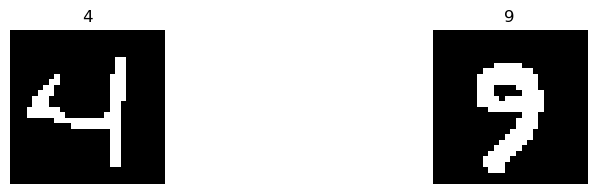

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 2))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(x[i].squeeze(), cmap="gray", vmin=0, vmax=1)
    plt.title(y[i].item())
    plt.axis("off")
plt.show()

# Define Transition Matrix for noising

In [7]:
T = 1000

betas = linear_beta_schedule(T).to(device)
Qs = build_all_transition_matrices(betas).to(device)

print(betas.shape)   # torch.Size([100])
print(Qs.shape)      # torch.Size([100, 2, 2])
print(Qs[0])
print(Qs[T-1])

torch.Size([1000])
torch.Size([1000, 2, 2])
tensor([[9.9990e-01, 1.0000e-04],
        [1.0000e-04, 9.9990e-01]], device='cuda:0')
tensor([[0.5000, 0.5000],
        [0.5000, 0.5000]], device='cuda:0')


In [8]:
# Define Qbar[t] = Q_1 * Q_2 * ... * Q_t
Qbar = compute_cumulative_transition_matrices(Qs, device=device)   # [T,2,2]

In [9]:
print("Qbar[2]:\n", Qbar[1])
print("Qbar[T]:\n", Qbar[T-1])

Qbar[2]:
 tensor([[9.9930e-01, 7.0028e-04],
        [7.0028e-04, 9.9930e-01]], device='cuda:0')
Qbar[T]:
 tensor([[0.5000, 0.5000],
        [0.5000, 0.5000]], device='cuda:0')


# Noise Data and Visualise

In [10]:
x[0].shape

torch.Size([1, 28, 28])

In [11]:
timesteps = [0, 5, 10, 30, T//2, 3*T//4, T-1]

results = []   # list of [(t, x_t_batch)]

for t in timesteps:
    xt_batch = sample_q_xt_given_x0(x, t=t, Qbar=Qbar)
    results.append((t, xt_batch.cpu()))

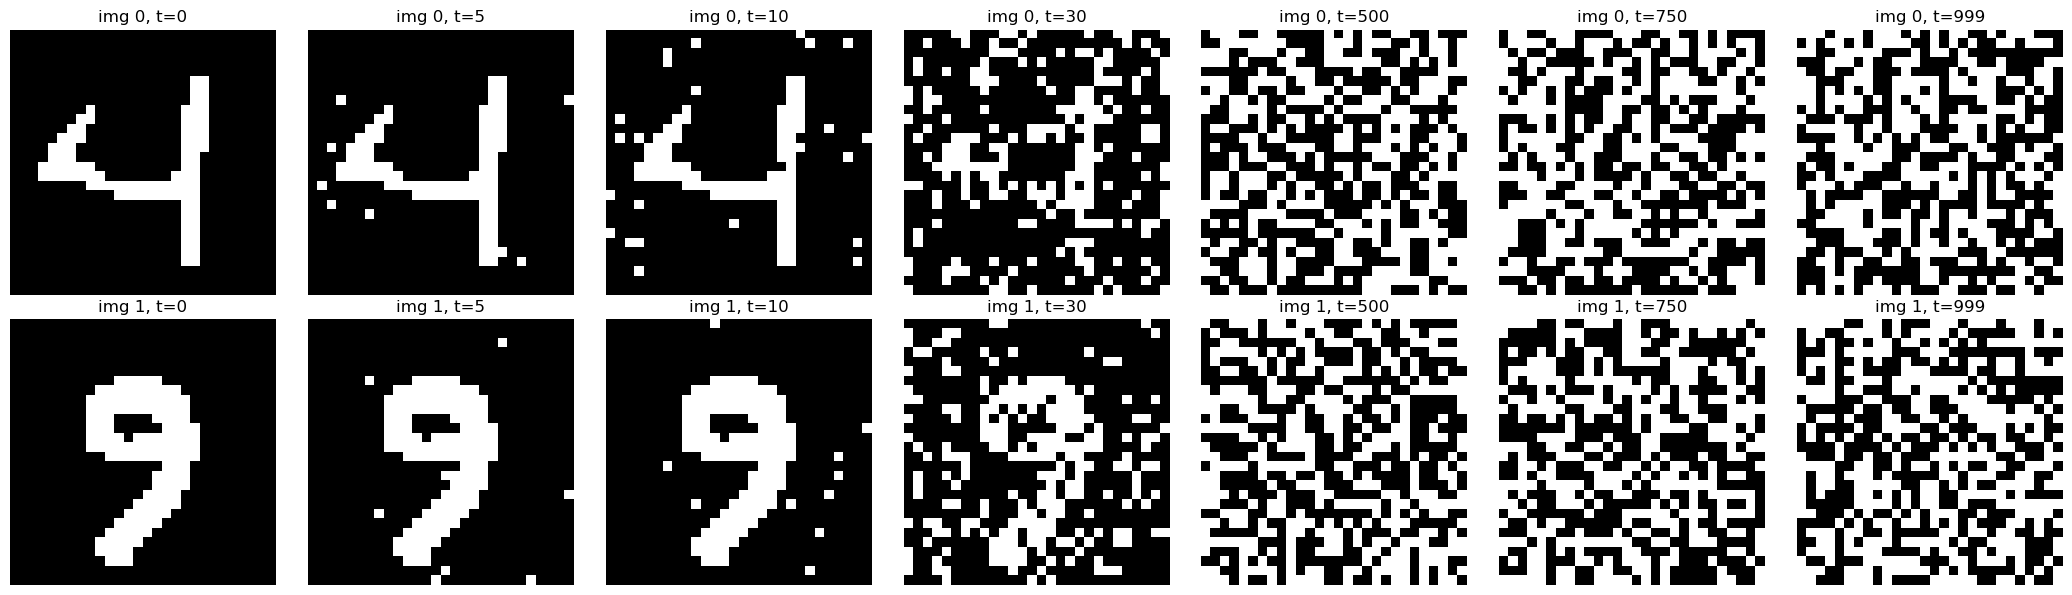

In [12]:
num_images = 2       # = 2
num_steps = len(timesteps)

plt.figure(figsize=(3 * num_steps, 3 * num_images))

for img_idx in range(num_images):  # loop over images in the batch
    for step_idx, (t, xt_batch) in enumerate(results):
        plt.subplot(num_images, num_steps, img_idx * num_steps + step_idx + 1)
        plt.imshow(xt_batch[img_idx].squeeze(), cmap="gray", vmin=0, vmax=1)
        plt.title(f"img {img_idx}, t={t}")
        plt.axis("off")

plt.tight_layout()
plt.show()

In [13]:
# Compute posterior Q(x_{t-1} | x_t, x_0) for t=99
t = 30   # random example
xt = sample_q_xt_given_x0(x, t=t, Qbar=Qbar)


q_posterior = compute_discrete_posterior(xt, x, t=t, Qs=Qs, Qbar=Qbar)

In [14]:
q_posterior.shape # (batch_size, channels, height, width, num_classes)

torch.Size([128, 1, 28, 28, 2])

In [15]:
# Example: get posterior distribution at pixel (2, 2) of first image in batch
q_posterior[0, 0, 5]

tensor([[0.0654, 0.9346],
        [0.9966, 0.0034],
        [0.9966, 0.0034],
        [0.9966, 0.0034],
        [0.9966, 0.0034],
        [0.9966, 0.0034],
        [0.0654, 0.9346],
        [0.9966, 0.0034],
        [0.9966, 0.0034],
        [0.0654, 0.9346],
        [0.9966, 0.0034],
        [0.9966, 0.0034],
        [0.9966, 0.0034],
        [0.9966, 0.0034],
        [0.9966, 0.0034],
        [0.9966, 0.0034],
        [0.9966, 0.0034],
        [0.9966, 0.0034],
        [0.9966, 0.0034],
        [0.0034, 0.9966],
        [0.0034, 0.9966],
        [0.9966, 0.0034],
        [0.9966, 0.0034],
        [0.9966, 0.0034],
        [0.0654, 0.9346],
        [0.9966, 0.0034],
        [0.9966, 0.0034],
        [0.9966, 0.0034]], device='cuda:0')

# Initialize model to predict posterior

In [18]:
model = SimpleD3PMMLP(T=T).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [19]:
x = x.to(device)
t = torch.randint(1, T, (x.shape[0],), device=device)   # shape [B]

In [20]:
xt = sample_q_xt_given_x0(x, t, Qbar).to(device)        # [B,1,28,28]

In [21]:
xt.shape

torch.Size([128, 1, 28, 28])

In [22]:
# this is p̃_theta(x0 | x_t))
logits_x0 = model(xt, t).to(device)

In [23]:
logits_x0.shape

torch.Size([128, 2, 28, 28])

In [24]:
# compute eqn (4)
p_theta = compute_p_theta_xtminus1_given_xt_from_p_tilde(logits_x0, xt, t, Qs, Qbar)   

In [25]:
p_theta.shape

torch.Size([128, 1, 28, 28, 2])

In [26]:
p_theta[0,0,1,1]

tensor([0.2980, 0.7020], device='cuda:0', grad_fn=<SelectBackward0>)

In [27]:
# KL divergence between q_posterior and p_theta
log_q = torch.log(q_posterior + 1e-20)
log_p = torch.log(p_theta + 1e-20)
kl = (q_posterior * (log_q - log_p)).sum(dim=-1).mean()

In [26]:
# auxilary term is CE
p_tilde = F.softmax(logits_x0, dim=1).to(device)         # [B,2,28,28]
p_x0 = p_tilde.gather(1, x)                  # [B,1,28,28]
aux_ce = -(torch.log(p_x0 + 1e-20)).mean()

In [27]:
lambda_aux = 0.1  # (arbitraty)
loss = kl + lambda_aux * aux_ce

loss

tensor(0.9603, device='cuda:0', grad_fn=<AddBackward0>)

In [28]:
# # ----- 10. Backprop + optimizer step -----
optimizer.zero_grad()
loss.backward()
optimizer.step()

print(f"loss={loss.item():.4f}, kl={kl.item():.4f}, aux_ce={aux_ce.item():.4f}, t_mean={t.float().mean().item():.1f}")

loss=0.9603, kl=0.8909, aux_ce=0.6941, t_mean=483.4


# Use a trainer to call train_one_epoch internally

In [16]:
T=1000

In [17]:
model = SimpleD3PMMLP(T=T).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [18]:
# Create trainer
trainer = Trainer(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=test_loader,   # optional
    Qs=Qs,
    Qbar=Qbar,
    T=T,
    device=device,
    lambda_aux=0.01,
    ckpt_dir="./training/checkpoints"
)


Epoch 1/30
  loss: 0.0033
  L_tminus1: 0.0003
  L0: 0.0003
  aux_ce: 0.2691
  steps: 469.0000
  val_aux_ce: 0.2634
  lr: 0.0010

  Denoising metrics on full train set:
    pixel_acc: 0.8691
    fg_acc: 0.1565
    bg_acc: 0.9777
    balanced_acc: 0.5671
    hamming: 0.1309
    mae: 0.1309


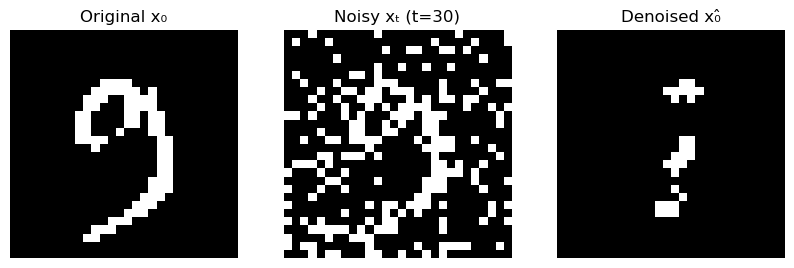

KeyboardInterrupt: 

In [ ]:
# New code
history = trainer.train(num_epochs=30, save_every=None, validate=False, print_every=1)


Epoch 1/30
  loss: 0.0030
  kl: 0.0003
  aux_ce: 0.2685
  steps: 469.0000
  lr: 0.0010

  Denoising metrics on full train set:
    pixel_acc: 0.8697
    fg_acc: 0.1682
    bg_acc: 0.9767
    balanced_acc: 0.5724
    hamming: 0.1303
    mae: 0.1303


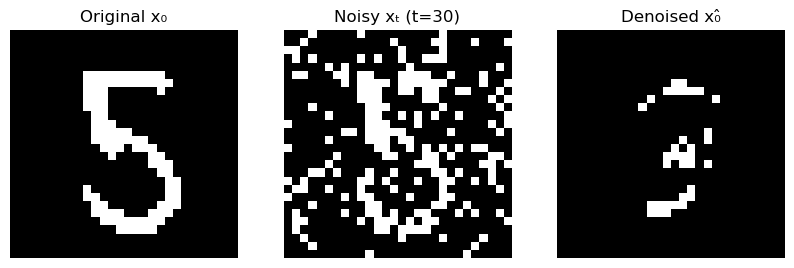


Epoch 2/30
  loss: 0.0029
  kl: 0.0003
  aux_ce: 0.2634
  steps: 469.0000
  lr: 0.0010

  Denoising metrics on full train set:
    pixel_acc: 0.8878
    fg_acc: 0.3712
    bg_acc: 0.9665
    balanced_acc: 0.6689
    hamming: 0.1122
    mae: 0.1122


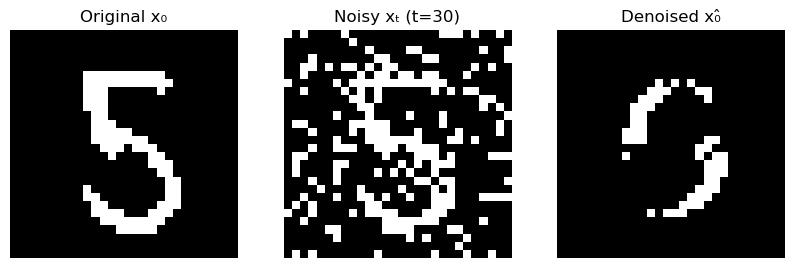


Epoch 3/30
  loss: 0.0028
  kl: 0.0002
  aux_ce: 0.2616
  steps: 469.0000
  lr: 0.0010

  Denoising metrics on full train set:
    pixel_acc: 0.9024
    fg_acc: 0.4758
    bg_acc: 0.9674
    balanced_acc: 0.7216
    hamming: 0.0976
    mae: 0.0976


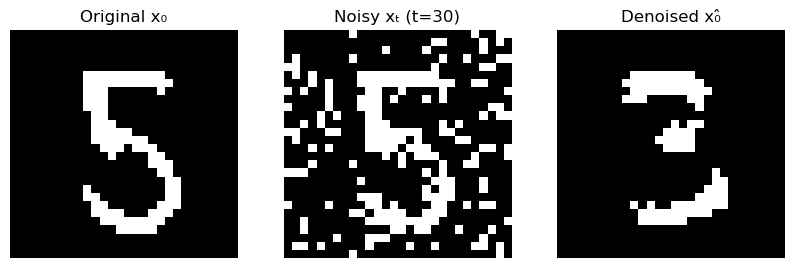


Epoch 4/30
  loss: 0.0028
  kl: 0.0002
  aux_ce: 0.2605
  steps: 469.0000
  lr: 0.0010

  Denoising metrics on full train set:
    pixel_acc: 0.9093
    fg_acc: 0.6262
    bg_acc: 0.9524
    balanced_acc: 0.7893
    hamming: 0.0907
    mae: 0.0907


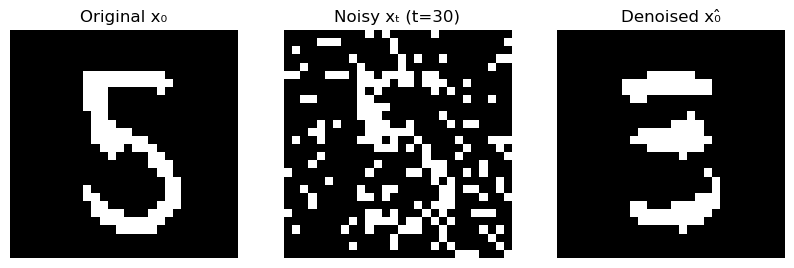


Epoch 5/30
  loss: 0.0028
  kl: 0.0002
  aux_ce: 0.2598
  steps: 469.0000
  lr: 0.0009

  Denoising metrics on full train set:
    pixel_acc: 0.9186
    fg_acc: 0.6365
    bg_acc: 0.9616
    balanced_acc: 0.7991
    hamming: 0.0814
    mae: 0.0814


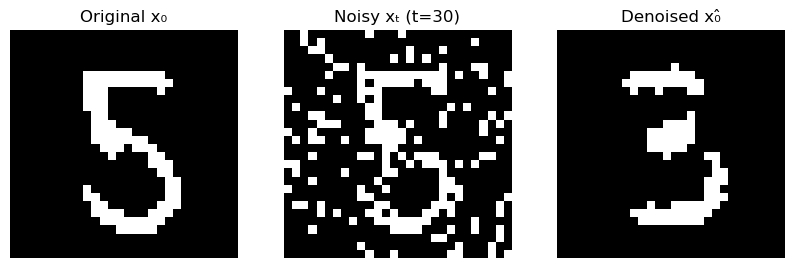


Epoch 6/30
  loss: 0.0028
  kl: 0.0002
  aux_ce: 0.2591
  steps: 469.0000
  lr: 0.0009

  Denoising metrics on full train set:
    pixel_acc: 0.9179
    fg_acc: 0.6821
    bg_acc: 0.9539
    balanced_acc: 0.8180
    hamming: 0.0821
    mae: 0.0821


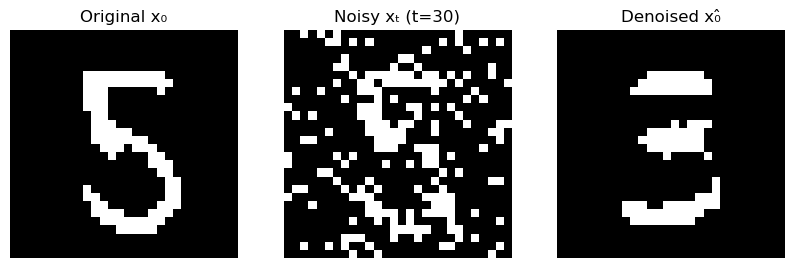


Epoch 7/30
  loss: 0.0028
  kl: 0.0002
  aux_ce: 0.2586
  steps: 469.0000
  lr: 0.0009

  Denoising metrics on full train set:
    pixel_acc: 0.9231
    fg_acc: 0.5929
    bg_acc: 0.9734
    balanced_acc: 0.7832
    hamming: 0.0769
    mae: 0.0769


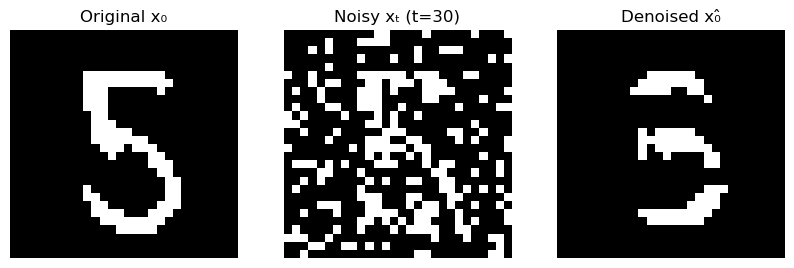


Epoch 8/30
  loss: 0.0028
  kl: 0.0002
  aux_ce: 0.2584
  steps: 469.0000
  lr: 0.0008

  Denoising metrics on full train set:
    pixel_acc: 0.9256
    fg_acc: 0.6504
    bg_acc: 0.9676
    balanced_acc: 0.8090
    hamming: 0.0744
    mae: 0.0744


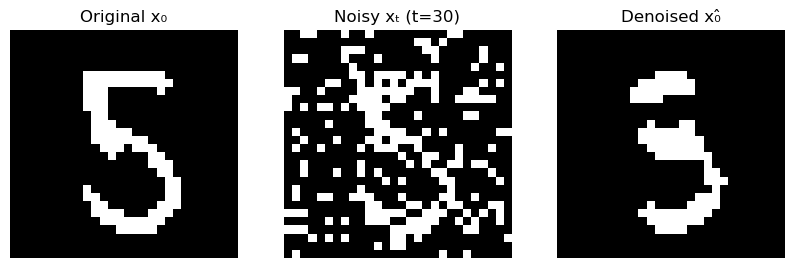


Epoch 9/30
  loss: 0.0028
  kl: 0.0002
  aux_ce: 0.2580
  steps: 469.0000
  lr: 0.0008

  Denoising metrics on full train set:
    pixel_acc: 0.9278
    fg_acc: 0.6792
    bg_acc: 0.9657
    balanced_acc: 0.8224
    hamming: 0.0722
    mae: 0.0722


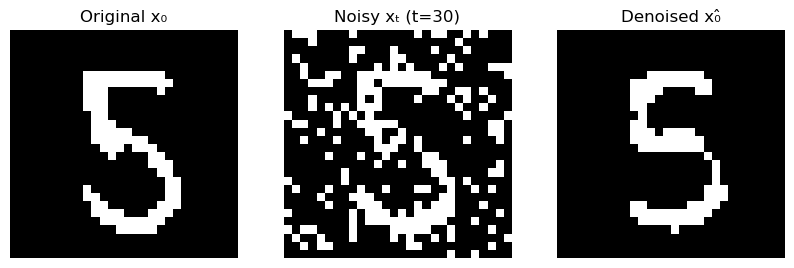


Epoch 10/30
  loss: 0.0027
  kl: 0.0002
  aux_ce: 0.2581
  steps: 469.0000
  lr: 0.0008

  Denoising metrics on full train set:
    pixel_acc: 0.9284
    fg_acc: 0.6627
    bg_acc: 0.9688
    balanced_acc: 0.8158
    hamming: 0.0716
    mae: 0.0716


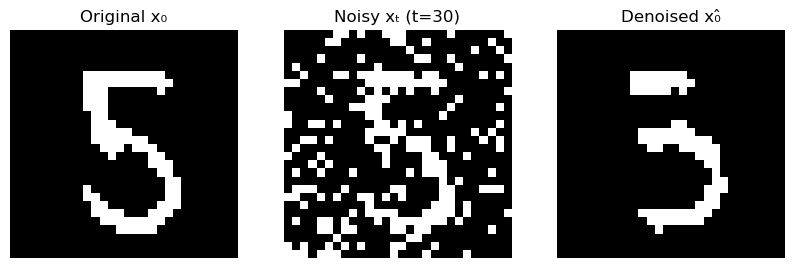


Epoch 11/30
  loss: 0.0027
  kl: 0.0002
  aux_ce: 0.2578
  steps: 469.0000
  lr: 0.0007

  Denoising metrics on full train set:
    pixel_acc: 0.9297
    fg_acc: 0.6929
    bg_acc: 0.9658
    balanced_acc: 0.8293
    hamming: 0.0703
    mae: 0.0703


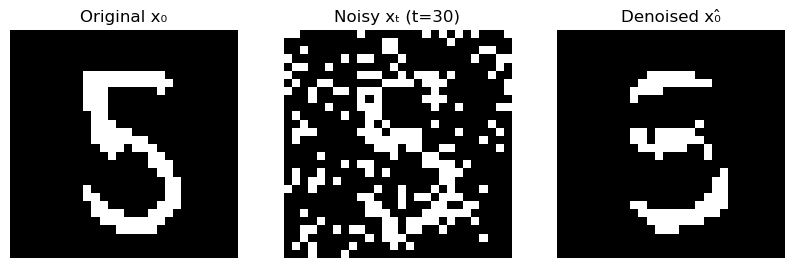


Epoch 12/30
  loss: 0.0027
  kl: 0.0002
  aux_ce: 0.2574
  steps: 469.0000
  lr: 0.0007

  Denoising metrics on full train set:
    pixel_acc: 0.9314
    fg_acc: 0.6777
    bg_acc: 0.9701
    balanced_acc: 0.8239
    hamming: 0.0686
    mae: 0.0686


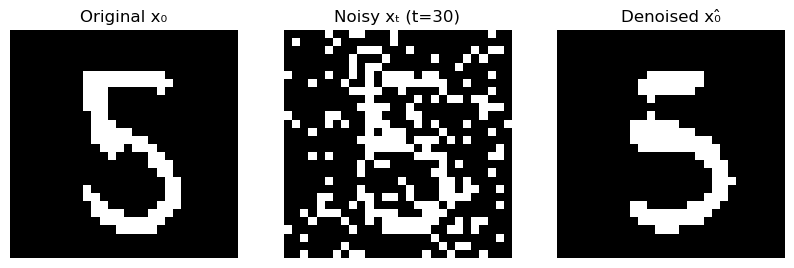


Epoch 13/30
  loss: 0.0027
  kl: 0.0002
  aux_ce: 0.2573
  steps: 469.0000
  lr: 0.0006

  Denoising metrics on full train set:
    pixel_acc: 0.9327
    fg_acc: 0.6800
    bg_acc: 0.9711
    balanced_acc: 0.8256
    hamming: 0.0673
    mae: 0.0673


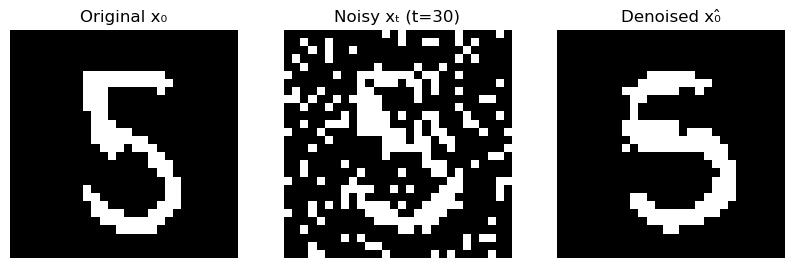


Epoch 14/30
  loss: 0.0027
  kl: 0.0002
  aux_ce: 0.2571
  steps: 469.0000
  lr: 0.0006

  Denoising metrics on full train set:
    pixel_acc: 0.9339
    fg_acc: 0.7083
    bg_acc: 0.9682
    balanced_acc: 0.8383
    hamming: 0.0661
    mae: 0.0661


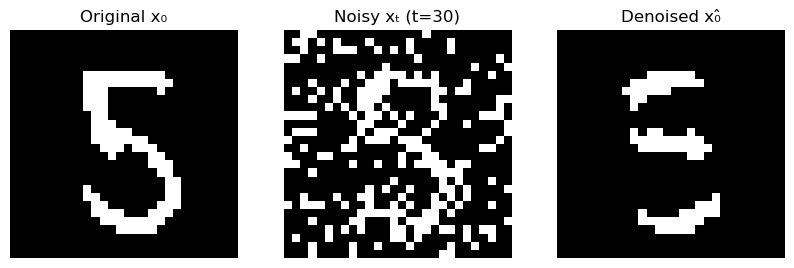


Epoch 15/30
  loss: 0.0027
  kl: 0.0002
  aux_ce: 0.2570
  steps: 469.0000
  lr: 0.0005

  Denoising metrics on full train set:
    pixel_acc: 0.9342
    fg_acc: 0.7657
    bg_acc: 0.9598
    balanced_acc: 0.8628
    hamming: 0.0658
    mae: 0.0658


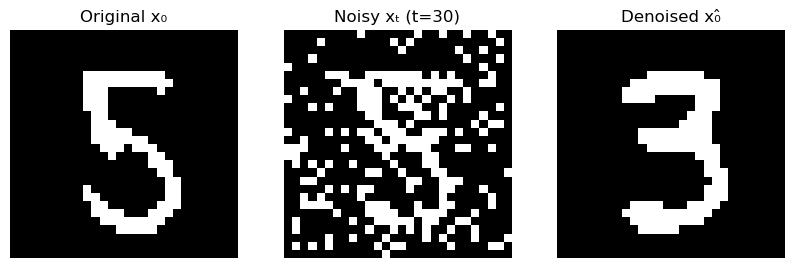


Epoch 16/30
  loss: 0.0027
  kl: 0.0002
  aux_ce: 0.2567
  steps: 469.0000
  lr: 0.0004

  Denoising metrics on full train set:
    pixel_acc: 0.9350
    fg_acc: 0.7549
    bg_acc: 0.9625
    balanced_acc: 0.8587
    hamming: 0.0650
    mae: 0.0650


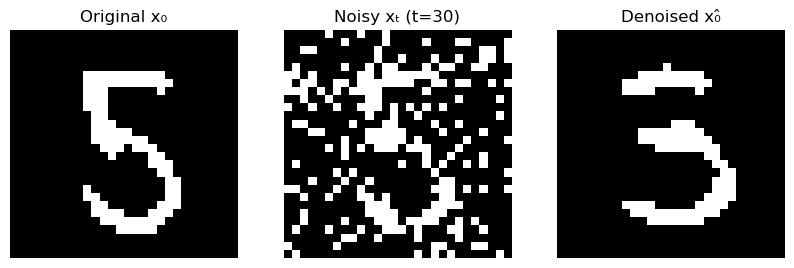


Epoch 17/30
  loss: 0.0027
  kl: 0.0001
  aux_ce: 0.2569
  steps: 469.0000
  lr: 0.0004

  Denoising metrics on full train set:
    pixel_acc: 0.9382
    fg_acc: 0.7317
    bg_acc: 0.9696
    balanced_acc: 0.8507
    hamming: 0.0618
    mae: 0.0618


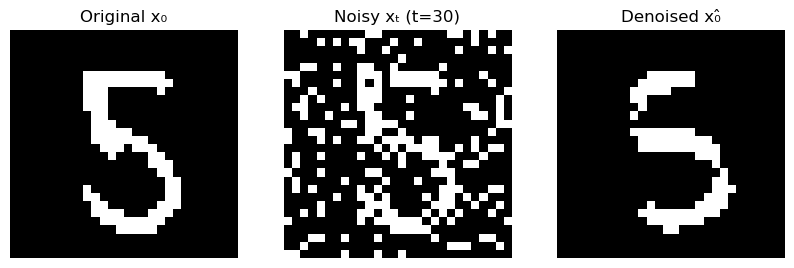


Epoch 18/30
  loss: 0.0027
  kl: 0.0001
  aux_ce: 0.2566
  steps: 469.0000
  lr: 0.0003

  Denoising metrics on full train set:
    pixel_acc: 0.9385
    fg_acc: 0.7224
    bg_acc: 0.9715
    balanced_acc: 0.8469
    hamming: 0.0615
    mae: 0.0615


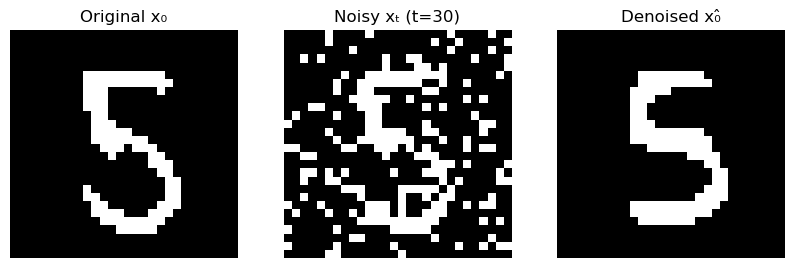


Epoch 19/30
  loss: 0.0027
  kl: 0.0001
  aux_ce: 0.2565
  steps: 469.0000
  lr: 0.0003

  Denoising metrics on full train set:
    pixel_acc: 0.9391
    fg_acc: 0.7015
    bg_acc: 0.9753
    balanced_acc: 0.8384
    hamming: 0.0609
    mae: 0.0609


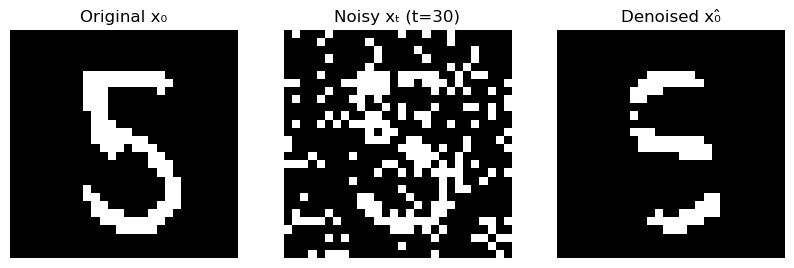


Epoch 20/30
  loss: 0.0027
  kl: 0.0001
  aux_ce: 0.2562
  steps: 469.0000
  lr: 0.0003

  Denoising metrics on full train set:
    pixel_acc: 0.9402
    fg_acc: 0.7437
    bg_acc: 0.9701
    balanced_acc: 0.8569
    hamming: 0.0598
    mae: 0.0598


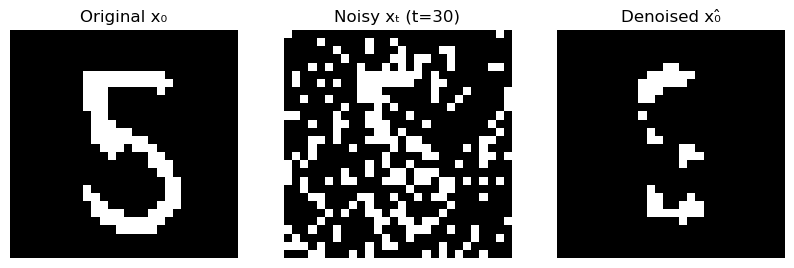


Epoch 21/30
  loss: 0.0027
  kl: 0.0001
  aux_ce: 0.2563
  steps: 469.0000
  lr: 0.0002

  Denoising metrics on full train set:
    pixel_acc: 0.9402
    fg_acc: 0.7153
    bg_acc: 0.9744
    balanced_acc: 0.8449
    hamming: 0.0598
    mae: 0.0598


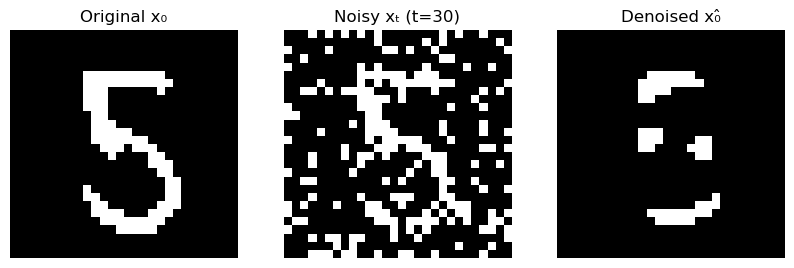


Epoch 22/30
  loss: 0.0027
  kl: 0.0001
  aux_ce: 0.2561
  steps: 469.0000
  lr: 0.0002

  Denoising metrics on full train set:
    pixel_acc: 0.9409
    fg_acc: 0.7470
    bg_acc: 0.9705
    balanced_acc: 0.8587
    hamming: 0.0591
    mae: 0.0591


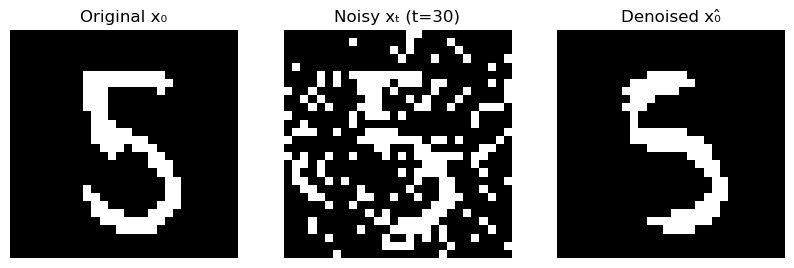


Epoch 23/30
  loss: 0.0027
  kl: 0.0001
  aux_ce: 0.2561
  steps: 469.0000
  lr: 0.0001

  Denoising metrics on full train set:
    pixel_acc: 0.9417
    fg_acc: 0.7385
    bg_acc: 0.9727
    balanced_acc: 0.8556
    hamming: 0.0583
    mae: 0.0583


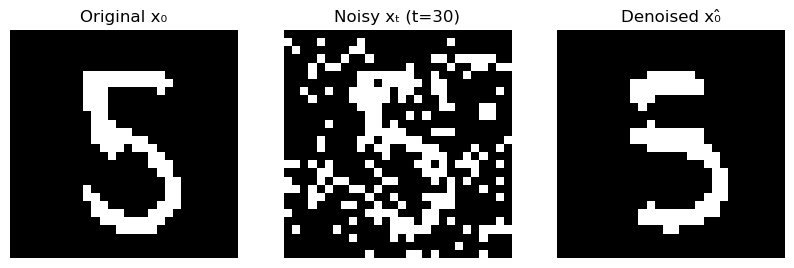


Epoch 24/30
  loss: 0.0027
  kl: 0.0001
  aux_ce: 0.2560
  steps: 469.0000
  lr: 0.0001

  Denoising metrics on full train set:
    pixel_acc: 0.9421
    fg_acc: 0.7591
    bg_acc: 0.9700
    balanced_acc: 0.8645
    hamming: 0.0579
    mae: 0.0579


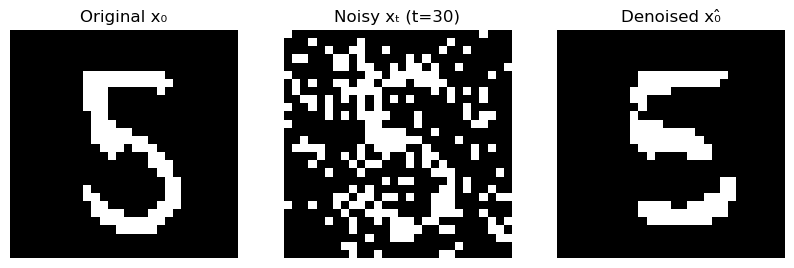


Epoch 25/30
  loss: 0.0027
  kl: 0.0001
  aux_ce: 0.2561
  steps: 469.0000
  lr: 0.0001

  Denoising metrics on full train set:
    pixel_acc: 0.9425
    fg_acc: 0.7541
    bg_acc: 0.9712
    balanced_acc: 0.8626
    hamming: 0.0575
    mae: 0.0575


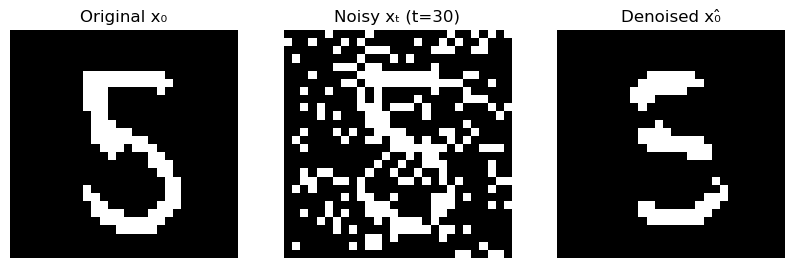


Epoch 26/30
  loss: 0.0027
  kl: 0.0001
  aux_ce: 0.2564
  steps: 469.0000
  lr: 0.0000

  Denoising metrics on full train set:
    pixel_acc: 0.9427
    fg_acc: 0.7548
    bg_acc: 0.9713
    balanced_acc: 0.8631
    hamming: 0.0573
    mae: 0.0573


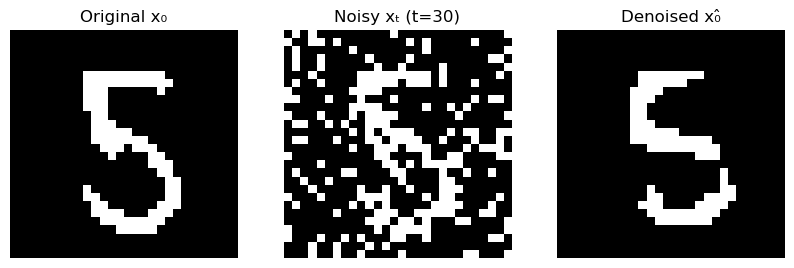


Epoch 27/30
  loss: 0.0027
  kl: 0.0001
  aux_ce: 0.2559
  steps: 469.0000
  lr: 0.0000

  Denoising metrics on full train set:
    pixel_acc: 0.9428
    fg_acc: 0.7464
    bg_acc: 0.9727
    balanced_acc: 0.8596
    hamming: 0.0572
    mae: 0.0572


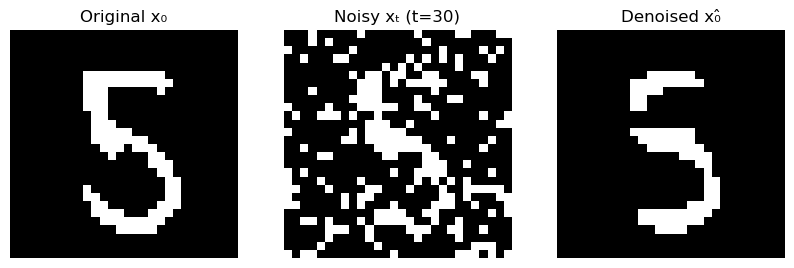


Epoch 28/30
  loss: 0.0027
  kl: 0.0001
  aux_ce: 0.2558
  steps: 469.0000
  lr: 0.0000

  Denoising metrics on full train set:
    pixel_acc: 0.9430
    fg_acc: 0.7535
    bg_acc: 0.9718
    balanced_acc: 0.8627
    hamming: 0.0570
    mae: 0.0570


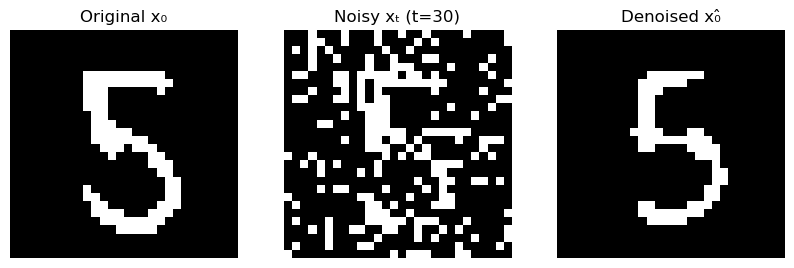


Epoch 29/30
  loss: 0.0027
  kl: 0.0001
  aux_ce: 0.2560
  steps: 469.0000
  lr: 0.0000

  Denoising metrics on full train set:
    pixel_acc: 0.9430
    fg_acc: 0.7540
    bg_acc: 0.9718
    balanced_acc: 0.8629
    hamming: 0.0570
    mae: 0.0570


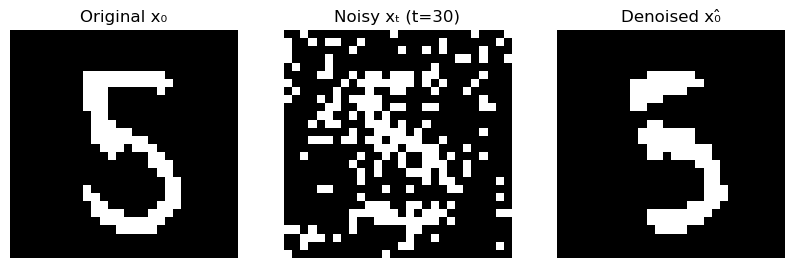


Epoch 30/30
  loss: 0.0027
  kl: 0.0001
  aux_ce: 0.2558
  steps: 469.0000
  lr: 0.0000

  Denoising metrics on full train set:
    pixel_acc: 0.9430
    fg_acc: 0.7531
    bg_acc: 0.9719
    balanced_acc: 0.8625
    hamming: 0.0570
    mae: 0.0570


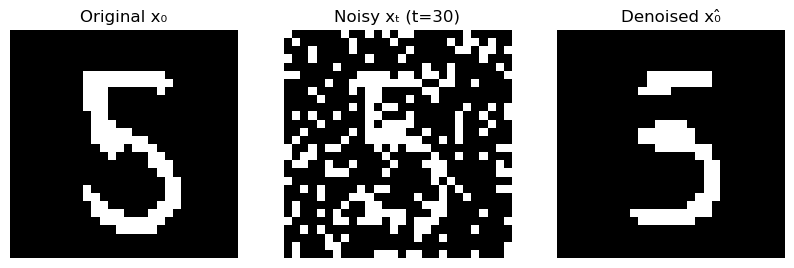

In [19]:
# Old code
history = trainer.train(num_epochs=30, save_every=None, validate=False, print_every=1)

# lambda 0.1

In [24]:
model = SimpleD3PMMLP(T=T).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [25]:
# Create trainer
trainer = Trainer(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=test_loader,   # optional
    Qs=Qs,
    Qbar=Qbar,
    T=T,
    device=device,
    lambda_aux=0.1,
    ckpt_dir="./training/checkpoints"
)


Epoch 1/30
  loss: 0.0271
  kl: 0.0003
  aux_ce: 0.2679
  steps: 469.0000
  lr: 0.0010

  Denoising metrics on full train set:
    pixel_acc: 0.8688
    fg_acc: 0.1856
    bg_acc: 0.9730
    balanced_acc: 0.5793
    hamming: 0.1312
    mae: 0.1312


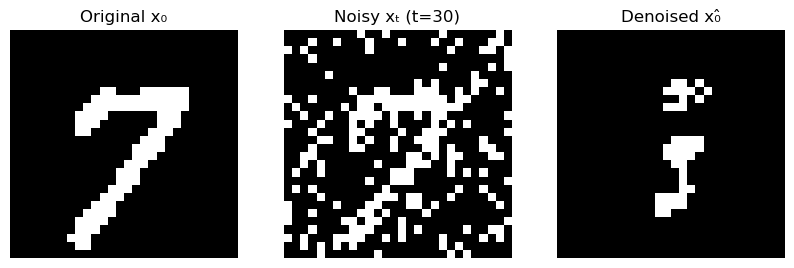


Epoch 3/30
  loss: 0.0264
  kl: 0.0002
  aux_ce: 0.2618
  steps: 469.0000
  lr: 0.0010

  Denoising metrics on full train set:
    pixel_acc: 0.8976
    fg_acc: 0.5084
    bg_acc: 0.9569
    balanced_acc: 0.7326
    hamming: 0.1024
    mae: 0.1024


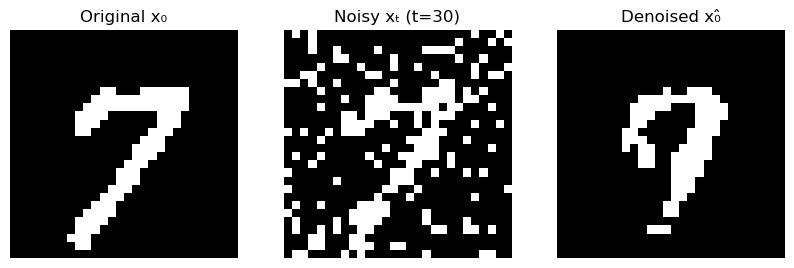


Epoch 6/30
  loss: 0.0261
  kl: 0.0002
  aux_ce: 0.2590
  steps: 469.0000
  lr: 0.0009

  Denoising metrics on full train set:
    pixel_acc: 0.9176
    fg_acc: 0.5924
    bg_acc: 0.9671
    balanced_acc: 0.7797
    hamming: 0.0824
    mae: 0.0824


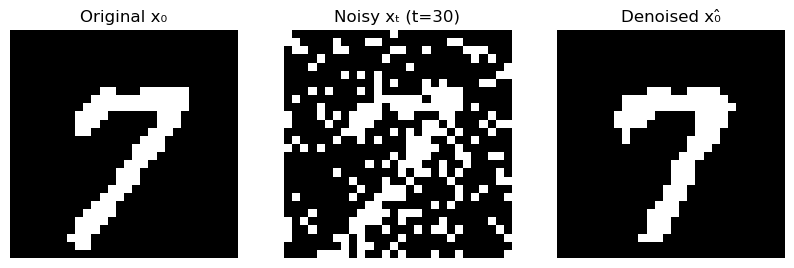


Epoch 9/30
  loss: 0.0259
  kl: 0.0002
  aux_ce: 0.2577
  steps: 469.0000
  lr: 0.0008

  Denoising metrics on full train set:
    pixel_acc: 0.9292
    fg_acc: 0.7254
    bg_acc: 0.9603
    balanced_acc: 0.8429
    hamming: 0.0708
    mae: 0.0708


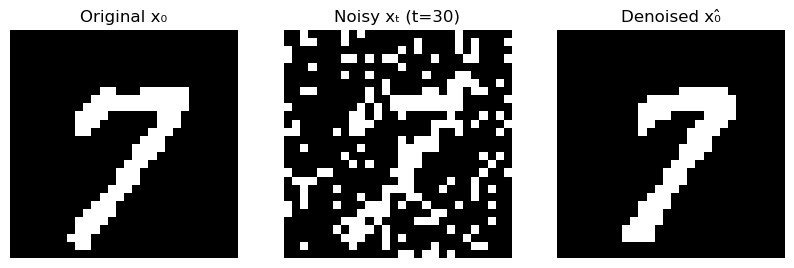


Epoch 12/30
  loss: 0.0259
  kl: 0.0002
  aux_ce: 0.2571
  steps: 469.0000
  lr: 0.0007

  Denoising metrics on full train set:
    pixel_acc: 0.9357
    fg_acc: 0.7311
    bg_acc: 0.9669
    balanced_acc: 0.8490
    hamming: 0.0643
    mae: 0.0643


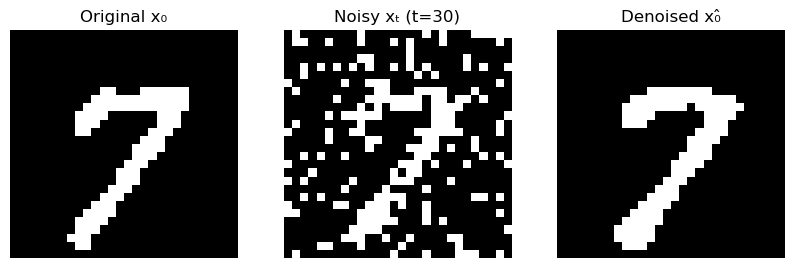


Epoch 15/30
  loss: 0.0258
  kl: 0.0001
  aux_ce: 0.2565
  steps: 469.0000
  lr: 0.0005

  Denoising metrics on full train set:
    pixel_acc: 0.9395
    fg_acc: 0.7379
    bg_acc: 0.9702
    balanced_acc: 0.8540
    hamming: 0.0605
    mae: 0.0605


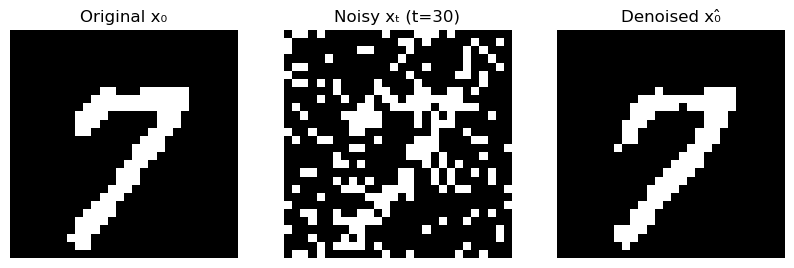


Epoch 18/30
  loss: 0.0257
  kl: 0.0001
  aux_ce: 0.2558
  steps: 469.0000
  lr: 0.0003

  Denoising metrics on full train set:
    pixel_acc: 0.9418
    fg_acc: 0.7823
    bg_acc: 0.9661
    balanced_acc: 0.8742
    hamming: 0.0582
    mae: 0.0582


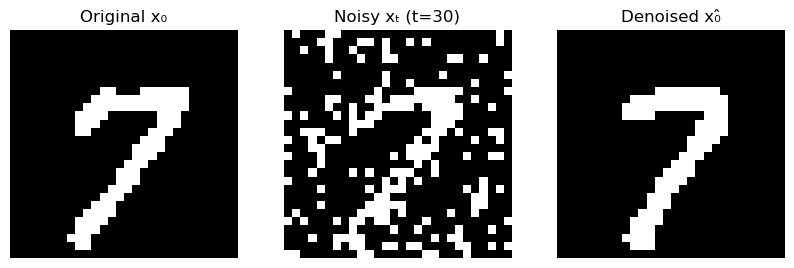


Epoch 21/30
  loss: 0.0257
  kl: 0.0001
  aux_ce: 0.2558
  steps: 469.0000
  lr: 0.0002

  Denoising metrics on full train set:
    pixel_acc: 0.9446
    fg_acc: 0.7672
    bg_acc: 0.9716
    balanced_acc: 0.8694
    hamming: 0.0554
    mae: 0.0554


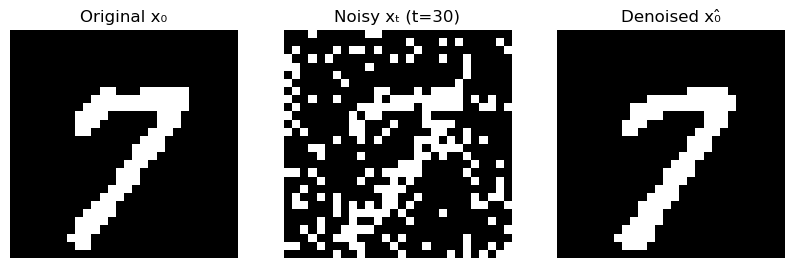


Epoch 24/30
  loss: 0.0257
  kl: 0.0001
  aux_ce: 0.2555
  steps: 469.0000
  lr: 0.0001

  Denoising metrics on full train set:
    pixel_acc: 0.9456
    fg_acc: 0.7676
    bg_acc: 0.9728
    balanced_acc: 0.8702
    hamming: 0.0544
    mae: 0.0544


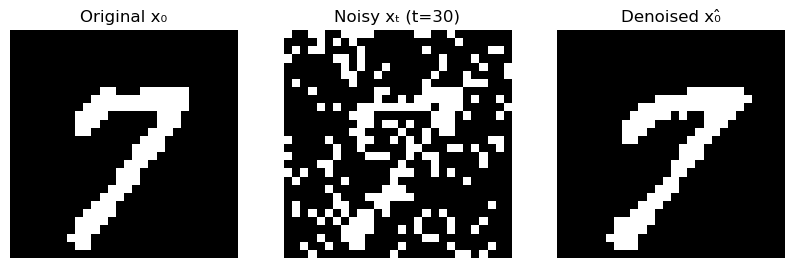


Epoch 27/30
  loss: 0.0257
  kl: 0.0001
  aux_ce: 0.2553
  steps: 469.0000
  lr: 0.0000

  Denoising metrics on full train set:
    pixel_acc: 0.9466
    fg_acc: 0.7874
    bg_acc: 0.9709
    balanced_acc: 0.8791
    hamming: 0.0534
    mae: 0.0534


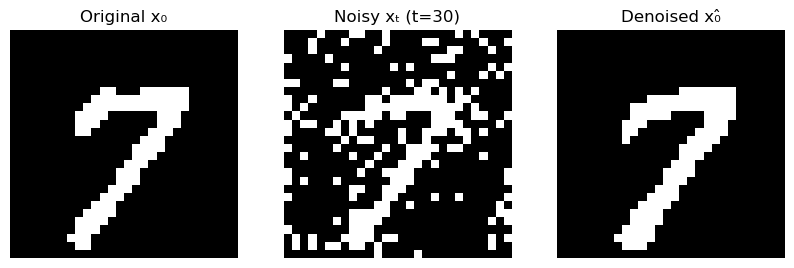


Epoch 30/30
  loss: 0.0257
  kl: 0.0001
  aux_ce: 0.2553
  steps: 469.0000
  lr: 0.0000

  Denoising metrics on full train set:
    pixel_acc: 0.9468
    fg_acc: 0.7827
    bg_acc: 0.9718
    balanced_acc: 0.8772
    hamming: 0.0532
    mae: 0.0532


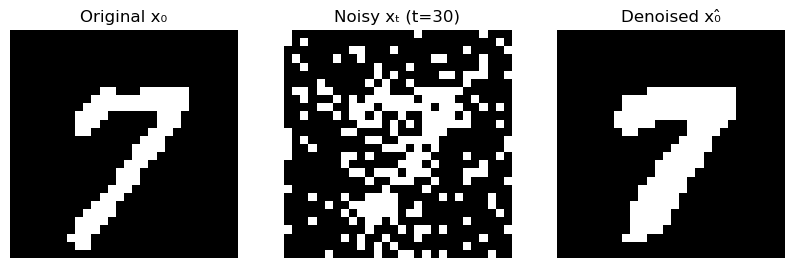

In [26]:
# New code
history = trainer.train(num_epochs=30, save_every=None, validate=False, print_every=3)

# Lambda = 1

In [30]:
model = SimpleD3PMMLP(T=T).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [31]:
# Create trainer
trainer = Trainer(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=test_loader,   # optional
    Qs=Qs,
    Qbar=Qbar,
    T=T,
    device=device,
    lambda_aux=1,
    ckpt_dir="./training/checkpoints"
)


Epoch 1/30
  loss: 0.2682
  kl: 0.0003
  aux_ce: 0.2679
  steps: 469.0000
  lr: 0.0010

  Denoising metrics on full train set:
    pixel_acc: 0.8690
    fg_acc: 0.1950
    bg_acc: 0.9718
    balanced_acc: 0.5834
    hamming: 0.1310
    mae: 0.1310


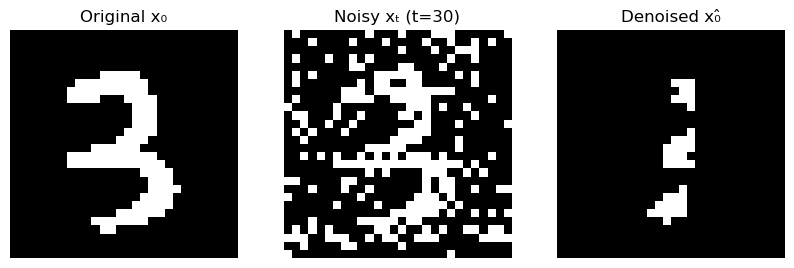


Epoch 3/30
  loss: 0.2622
  kl: 0.0002
  aux_ce: 0.2620
  steps: 469.0000
  lr: 0.0010

  Denoising metrics on full train set:
    pixel_acc: 0.8992
    fg_acc: 0.4987
    bg_acc: 0.9602
    balanced_acc: 0.7295
    hamming: 0.1008
    mae: 0.1008


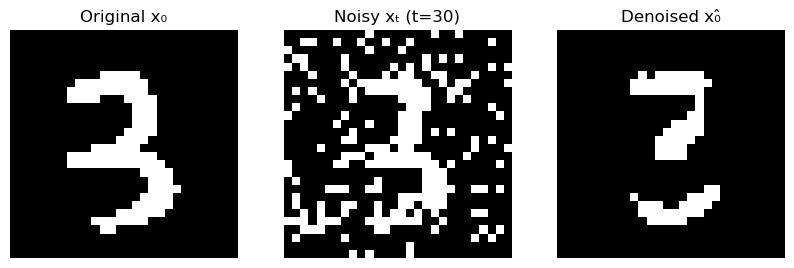


Epoch 6/30
  loss: 0.2590
  kl: 0.0002
  aux_ce: 0.2589
  steps: 469.0000
  lr: 0.0009

  Denoising metrics on full train set:
    pixel_acc: 0.9199
    fg_acc: 0.5895
    bg_acc: 0.9702
    balanced_acc: 0.7799
    hamming: 0.0801
    mae: 0.0801


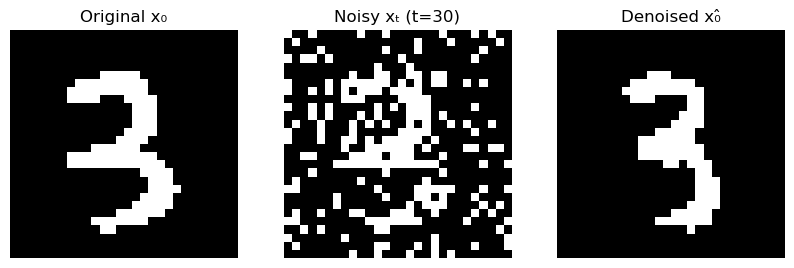


Epoch 9/30
  loss: 0.2580
  kl: 0.0002
  aux_ce: 0.2578
  steps: 469.0000
  lr: 0.0008

  Denoising metrics on full train set:
    pixel_acc: 0.9310
    fg_acc: 0.7010
    bg_acc: 0.9660
    balanced_acc: 0.8335
    hamming: 0.0690
    mae: 0.0690


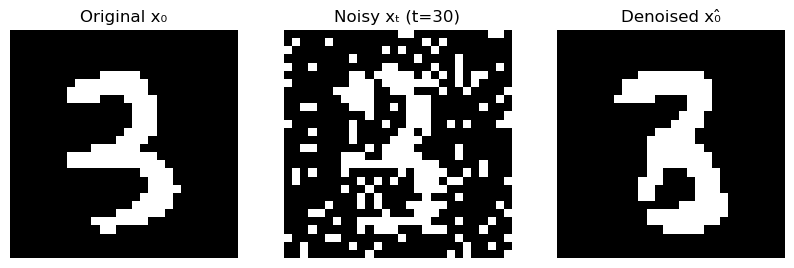


Epoch 12/30
  loss: 0.2572
  kl: 0.0002
  aux_ce: 0.2570
  steps: 469.0000
  lr: 0.0007

  Denoising metrics on full train set:
    pixel_acc: 0.9352
    fg_acc: 0.6931
    bg_acc: 0.9721
    balanced_acc: 0.8326
    hamming: 0.0648
    mae: 0.0648


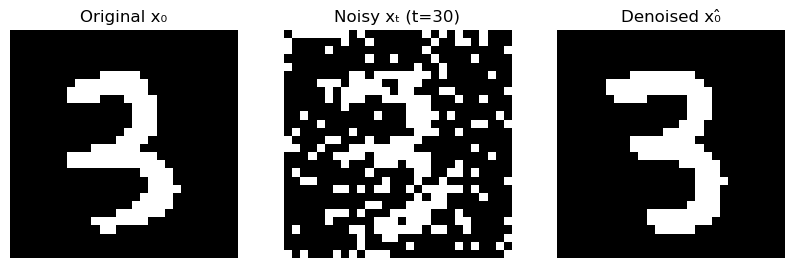


Epoch 15/30
  loss: 0.2567
  kl: 0.0001
  aux_ce: 0.2565
  steps: 469.0000
  lr: 0.0005

  Denoising metrics on full train set:
    pixel_acc: 0.9407
    fg_acc: 0.7506
    bg_acc: 0.9697
    balanced_acc: 0.8601
    hamming: 0.0593
    mae: 0.0593


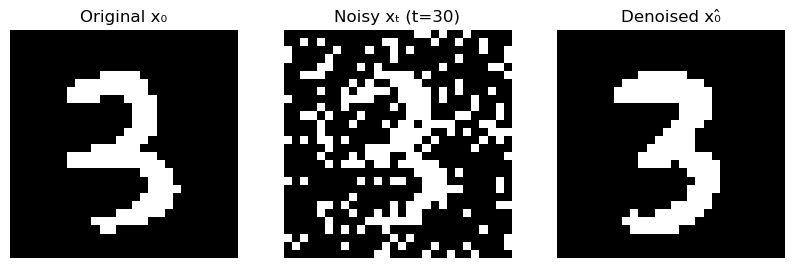


Epoch 18/30
  loss: 0.2560
  kl: 0.0001
  aux_ce: 0.2559
  steps: 469.0000
  lr: 0.0003

  Denoising metrics on full train set:
    pixel_acc: 0.9436
    fg_acc: 0.7639
    bg_acc: 0.9710
    balanced_acc: 0.8674
    hamming: 0.0564
    mae: 0.0564


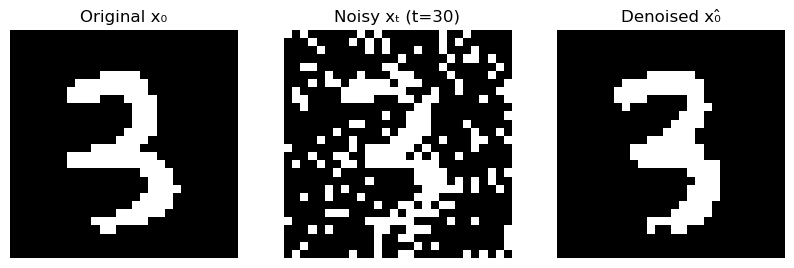


Epoch 21/30
  loss: 0.2557
  kl: 0.0001
  aux_ce: 0.2556
  steps: 469.0000
  lr: 0.0002

  Denoising metrics on full train set:
    pixel_acc: 0.9456
    fg_acc: 0.7653
    bg_acc: 0.9731
    balanced_acc: 0.8692
    hamming: 0.0544
    mae: 0.0544


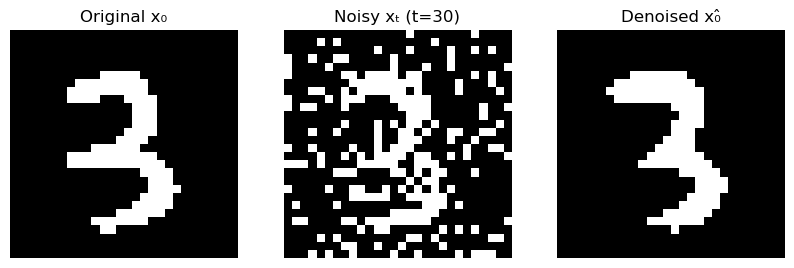


Epoch 24/30
  loss: 0.2554
  kl: 0.0001
  aux_ce: 0.2553
  steps: 469.0000
  lr: 0.0001

  Denoising metrics on full train set:
    pixel_acc: 0.9472
    fg_acc: 0.7865
    bg_acc: 0.9717
    balanced_acc: 0.8791
    hamming: 0.0528
    mae: 0.0528


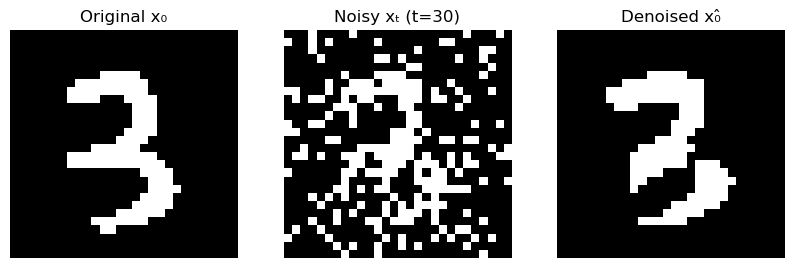


Epoch 27/30
  loss: 0.2553
  kl: 0.0001
  aux_ce: 0.2552
  steps: 469.0000
  lr: 0.0000

  Denoising metrics on full train set:
    pixel_acc: 0.9481
    fg_acc: 0.7875
    bg_acc: 0.9726
    balanced_acc: 0.8801
    hamming: 0.0519
    mae: 0.0519


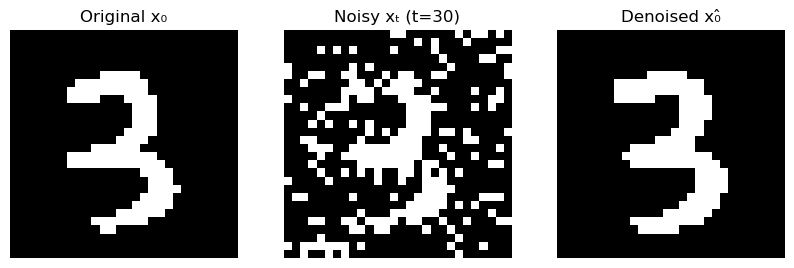


Epoch 30/30
  loss: 0.2552
  kl: 0.0001
  aux_ce: 0.2551
  steps: 469.0000
  lr: 0.0000

  Denoising metrics on full train set:
    pixel_acc: 0.9483
    fg_acc: 0.7834
    bg_acc: 0.9735
    balanced_acc: 0.8784
    hamming: 0.0517
    mae: 0.0517


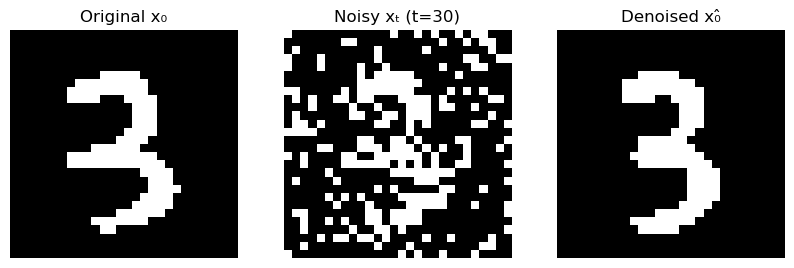

In [32]:
# New code
history = trainer.train(num_epochs=30, save_every=None, validate=False, print_every=3)

## CNN

In [33]:
cnn_model = SimpleD3PMCNN(T=T).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# Create trainer
trainer = Trainer(
    model=cnn_model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=test_loader,   # optional
    Qs=Qs,
    Qbar=Qbar,
    T=T,
    device=device,
    lambda_aux=0.01,
    ckpt_dir="./training/checkpoints"
)



Epoch 1/30
  loss: 0.0085
  kl: 0.0007
  aux_ce: 0.7824
  steps: 469.0000
  val_aux_ce: 0.7815
  lr: 0.0010

  Denoising metrics on full train set:
    pixel_acc: 0.5807
    fg_acc: 0.9635
    bg_acc: 0.5224
    balanced_acc: 0.7430
    hamming: 0.4193
    mae: 0.4193


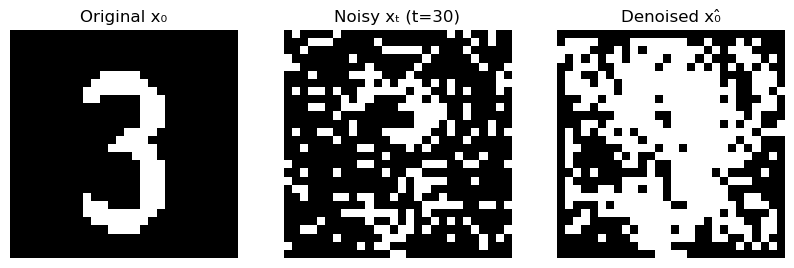


Epoch 2/30
  loss: 0.0085
  kl: 0.0007
  aux_ce: 0.7828
  steps: 469.0000
  val_aux_ce: 0.7812
  lr: 0.0010

  Denoising metrics on full train set:
    pixel_acc: 0.5806
    fg_acc: 0.9637
    bg_acc: 0.5222
    balanced_acc: 0.7429
    hamming: 0.4194
    mae: 0.4194


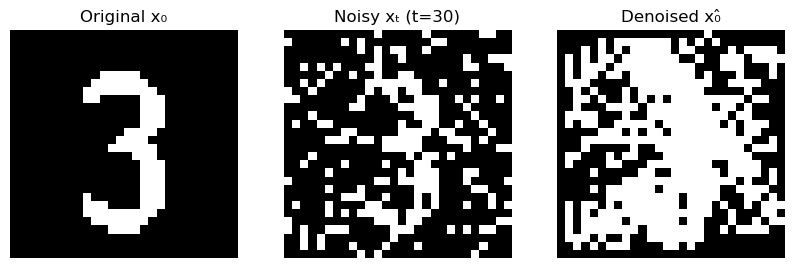


Epoch 3/30
  loss: 0.0085
  kl: 0.0007
  aux_ce: 0.7825
  steps: 469.0000
  val_aux_ce: 0.7814
  lr: 0.0010

  Denoising metrics on full train set:
    pixel_acc: 0.5808
    fg_acc: 0.9636
    bg_acc: 0.5224
    balanced_acc: 0.7430
    hamming: 0.4192
    mae: 0.4192


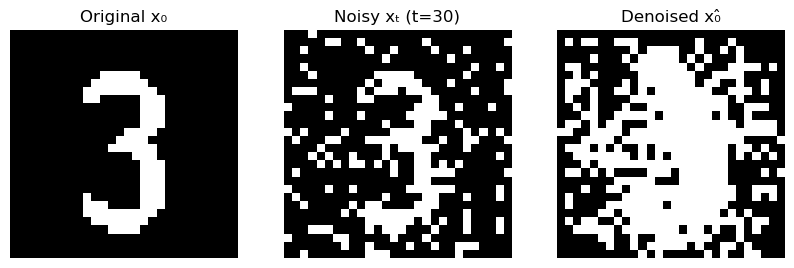


Epoch 4/30
  loss: 0.0085
  kl: 0.0007
  aux_ce: 0.7823
  steps: 469.0000
  val_aux_ce: 0.7809
  lr: 0.0010

  Denoising metrics on full train set:
    pixel_acc: 0.5806
    fg_acc: 0.9636
    bg_acc: 0.5222
    balanced_acc: 0.7429
    hamming: 0.4194
    mae: 0.4194


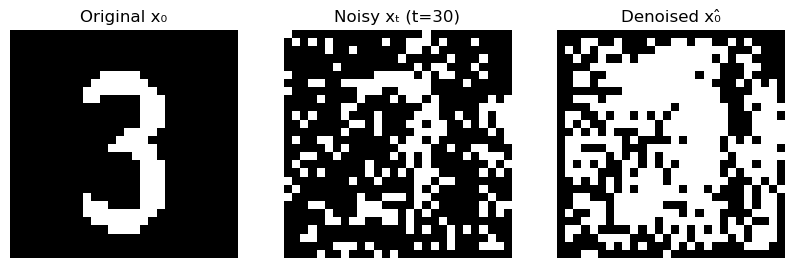


Epoch 5/30
  loss: 0.0085
  kl: 0.0007
  aux_ce: 0.7821
  steps: 469.0000
  val_aux_ce: 0.7818
  lr: 0.0009

  Denoising metrics on full train set:
    pixel_acc: 0.5806
    fg_acc: 0.9637
    bg_acc: 0.5223
    balanced_acc: 0.7430
    hamming: 0.4194
    mae: 0.4194


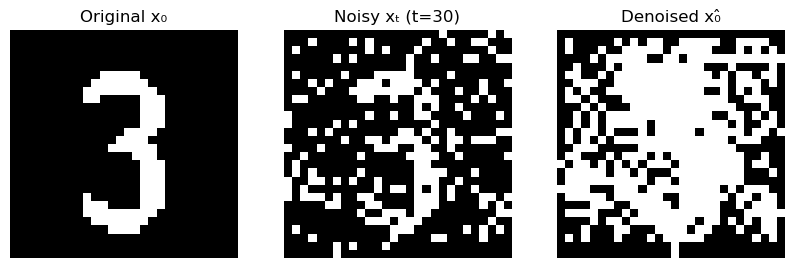


Epoch 6/30
  loss: 0.0085
  kl: 0.0007
  aux_ce: 0.7823
  steps: 469.0000
  val_aux_ce: 0.7814
  lr: 0.0009

  Denoising metrics on full train set:
    pixel_acc: 0.5806
    fg_acc: 0.9636
    bg_acc: 0.5223
    balanced_acc: 0.7429
    hamming: 0.4194
    mae: 0.4194


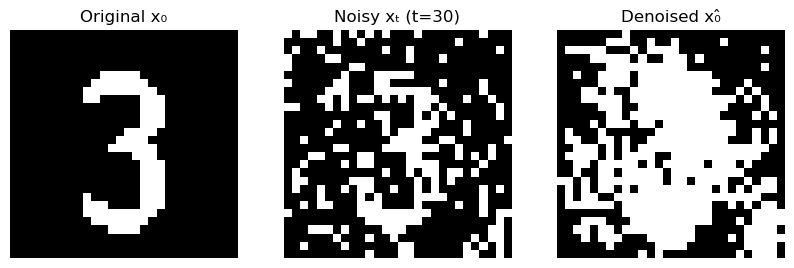


Epoch 7/30
  loss: 0.0085
  kl: 0.0007
  aux_ce: 0.7828
  steps: 469.0000
  val_aux_ce: 0.7810
  lr: 0.0009

  Denoising metrics on full train set:
    pixel_acc: 0.5806
    fg_acc: 0.9636
    bg_acc: 0.5223
    balanced_acc: 0.7429
    hamming: 0.4194
    mae: 0.4194


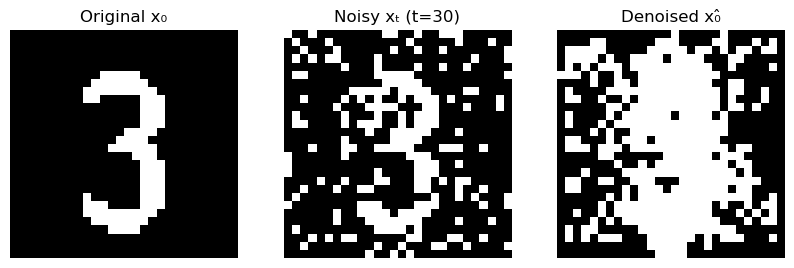


Epoch 8/30
  loss: 0.0085
  kl: 0.0007
  aux_ce: 0.7826
  steps: 469.0000
  val_aux_ce: 0.7819
  lr: 0.0008

  Denoising metrics on full train set:
    pixel_acc: 0.5806
    fg_acc: 0.9637
    bg_acc: 0.5222
    balanced_acc: 0.7429
    hamming: 0.4194
    mae: 0.4194


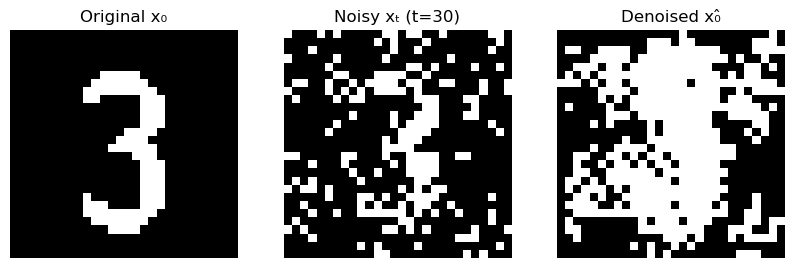


Epoch 9/30
  loss: 0.0085
  kl: 0.0007
  aux_ce: 0.7828
  steps: 469.0000
  val_aux_ce: 0.7813
  lr: 0.0008

  Denoising metrics on full train set:
    pixel_acc: 0.5807
    fg_acc: 0.9636
    bg_acc: 0.5224
    balanced_acc: 0.7430
    hamming: 0.4193
    mae: 0.4193


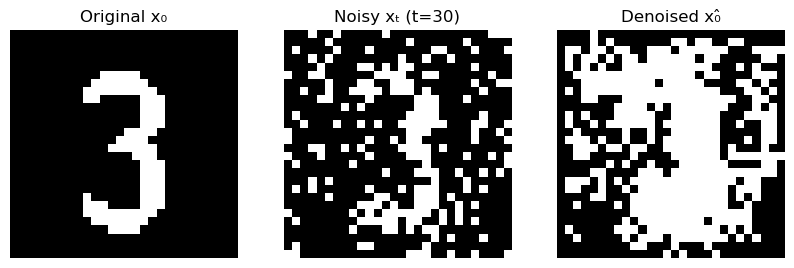


Epoch 10/30
  loss: 0.0085
  kl: 0.0007
  aux_ce: 0.7823
  steps: 469.0000
  val_aux_ce: 0.7814
  lr: 0.0008

  Denoising metrics on full train set:
    pixel_acc: 0.5805
    fg_acc: 0.9637
    bg_acc: 0.5222
    balanced_acc: 0.7429
    hamming: 0.4195
    mae: 0.4195


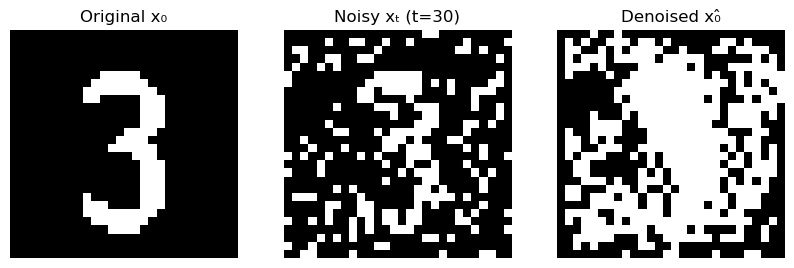


Epoch 11/30
  loss: 0.0086
  kl: 0.0007
  aux_ce: 0.7820
  steps: 469.0000
  val_aux_ce: 0.7815
  lr: 0.0007

  Denoising metrics on full train set:
    pixel_acc: 0.5806
    fg_acc: 0.9636
    bg_acc: 0.5222
    balanced_acc: 0.7429
    hamming: 0.4194
    mae: 0.4194


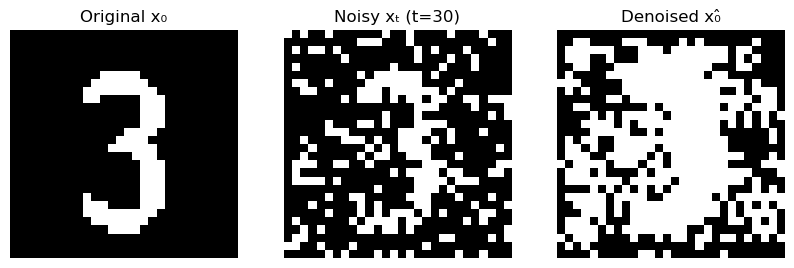


Epoch 12/30
  loss: 0.0085
  kl: 0.0007
  aux_ce: 0.7821
  steps: 469.0000
  val_aux_ce: 0.7823
  lr: 0.0007

  Denoising metrics on full train set:
    pixel_acc: 0.5806
    fg_acc: 0.9637
    bg_acc: 0.5222
    balanced_acc: 0.7429
    hamming: 0.4194
    mae: 0.4194


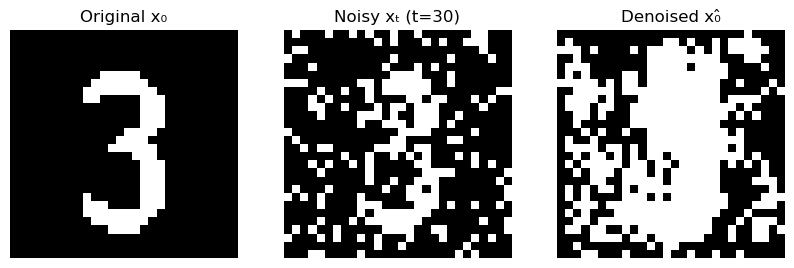


Epoch 13/30
  loss: 0.0085
  kl: 0.0007
  aux_ce: 0.7824
  steps: 469.0000
  val_aux_ce: 0.7815
  lr: 0.0006

  Denoising metrics on full train set:
    pixel_acc: 0.5807
    fg_acc: 0.9637
    bg_acc: 0.5223
    balanced_acc: 0.7430
    hamming: 0.4193
    mae: 0.4193


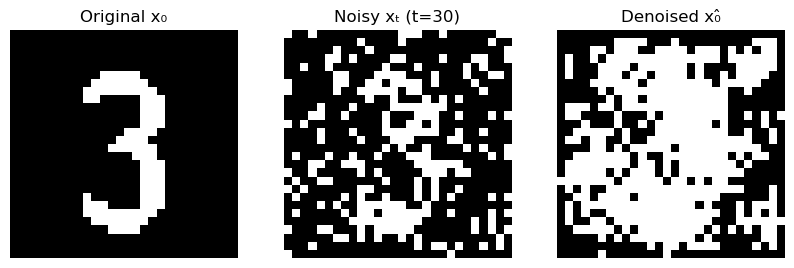


Epoch 14/30
  loss: 0.0086
  kl: 0.0007
  aux_ce: 0.7826
  steps: 469.0000
  val_aux_ce: 0.7822
  lr: 0.0006

  Denoising metrics on full train set:
    pixel_acc: 0.5805
    fg_acc: 0.9636
    bg_acc: 0.5222
    balanced_acc: 0.7429
    hamming: 0.4195
    mae: 0.4195


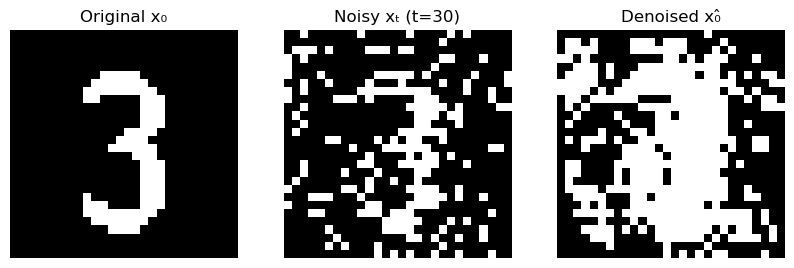


Epoch 15/30
  loss: 0.0085
  kl: 0.0007
  aux_ce: 0.7824
  steps: 469.0000
  val_aux_ce: 0.7814
  lr: 0.0005

  Denoising metrics on full train set:
    pixel_acc: 0.5808
    fg_acc: 0.9636
    bg_acc: 0.5224
    balanced_acc: 0.7430
    hamming: 0.4192
    mae: 0.4192


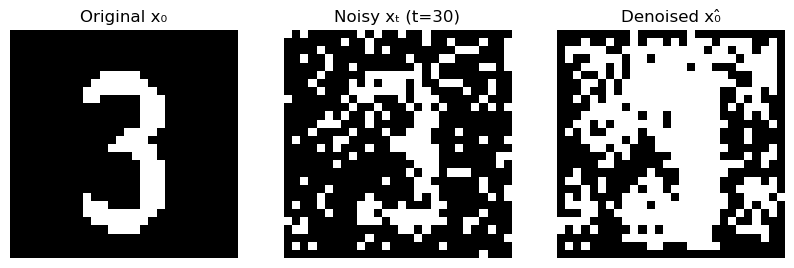


Epoch 16/30
  loss: 0.0085
  kl: 0.0007
  aux_ce: 0.7827
  steps: 469.0000
  val_aux_ce: 0.7820
  lr: 0.0004

  Denoising metrics on full train set:
    pixel_acc: 0.5806
    fg_acc: 0.9635
    bg_acc: 0.5222
    balanced_acc: 0.7429
    hamming: 0.4194
    mae: 0.4194


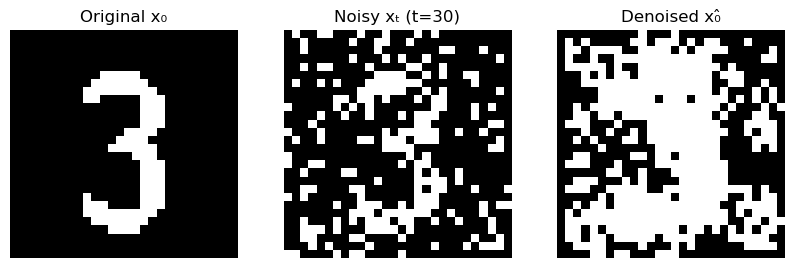


Epoch 17/30
  loss: 0.0085
  kl: 0.0007
  aux_ce: 0.7820
  steps: 469.0000
  val_aux_ce: 0.7821
  lr: 0.0004

  Denoising metrics on full train set:
    pixel_acc: 0.5806
    fg_acc: 0.9636
    bg_acc: 0.5222
    balanced_acc: 0.7429
    hamming: 0.4194
    mae: 0.4194


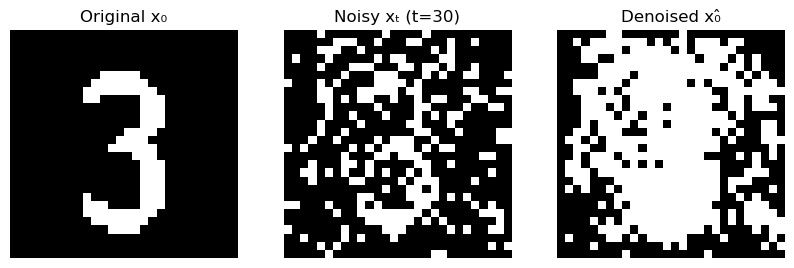


Epoch 18/30
  loss: 0.0085
  kl: 0.0007
  aux_ce: 0.7825
  steps: 469.0000
  val_aux_ce: 0.7814
  lr: 0.0003

  Denoising metrics on full train set:
    pixel_acc: 0.5806
    fg_acc: 0.9636
    bg_acc: 0.5222
    balanced_acc: 0.7429
    hamming: 0.4194
    mae: 0.4194


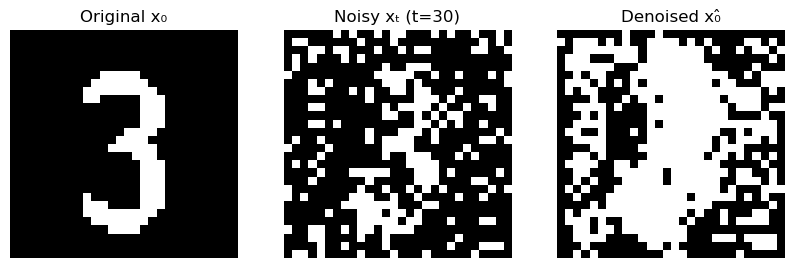


Epoch 19/30
  loss: 0.0085
  kl: 0.0007
  aux_ce: 0.7825
  steps: 469.0000
  val_aux_ce: 0.7806
  lr: 0.0003

  Denoising metrics on full train set:
    pixel_acc: 0.5806
    fg_acc: 0.9637
    bg_acc: 0.5222
    balanced_acc: 0.7430
    hamming: 0.4194
    mae: 0.4194


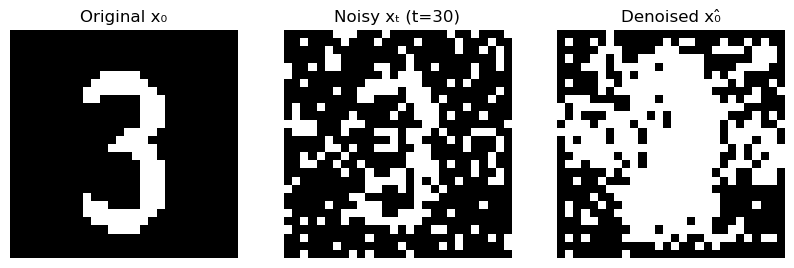


Epoch 20/30
  loss: 0.0085
  kl: 0.0007
  aux_ce: 0.7826
  steps: 469.0000
  val_aux_ce: 0.7812
  lr: 0.0003

  Denoising metrics on full train set:
    pixel_acc: 0.5807
    fg_acc: 0.9636
    bg_acc: 0.5224
    balanced_acc: 0.7430
    hamming: 0.4193
    mae: 0.4193


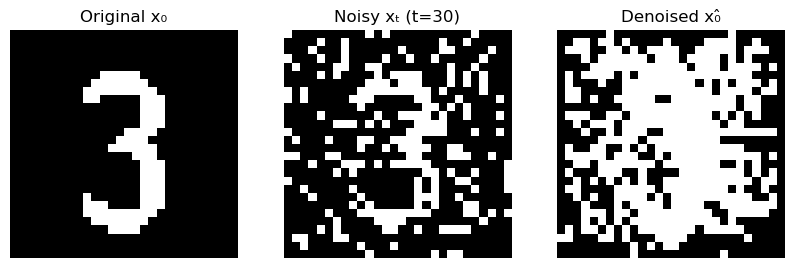


Epoch 21/30
  loss: 0.0085
  kl: 0.0007
  aux_ce: 0.7823
  steps: 469.0000
  val_aux_ce: 0.7820
  lr: 0.0002

  Denoising metrics on full train set:
    pixel_acc: 0.5807
    fg_acc: 0.9638
    bg_acc: 0.5223
    balanced_acc: 0.7430
    hamming: 0.4193
    mae: 0.4193


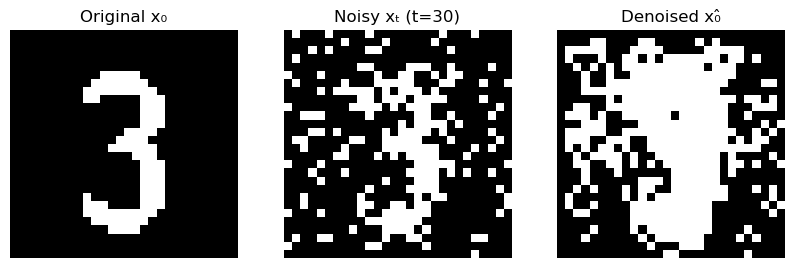


Epoch 22/30
  loss: 0.0085
  kl: 0.0007
  aux_ce: 0.7826
  steps: 469.0000
  val_aux_ce: 0.7811
  lr: 0.0002

  Denoising metrics on full train set:
    pixel_acc: 0.5805
    fg_acc: 0.9635
    bg_acc: 0.5222
    balanced_acc: 0.7428
    hamming: 0.4195
    mae: 0.4195


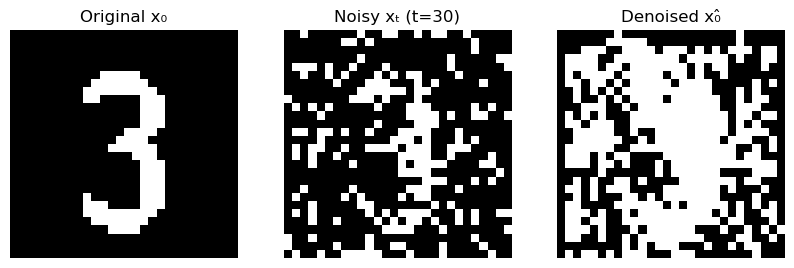


Epoch 23/30
  loss: 0.0086
  kl: 0.0007
  aux_ce: 0.7824
  steps: 469.0000
  val_aux_ce: 0.7823
  lr: 0.0001

  Denoising metrics on full train set:
    pixel_acc: 0.5804
    fg_acc: 0.9635
    bg_acc: 0.5221
    balanced_acc: 0.7428
    hamming: 0.4196
    mae: 0.4196


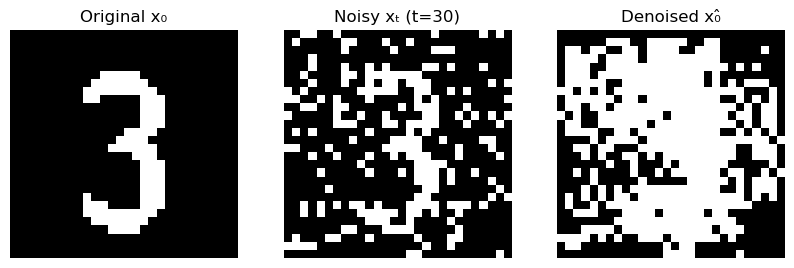


Epoch 24/30
  loss: 0.0085
  kl: 0.0007
  aux_ce: 0.7824
  steps: 469.0000
  val_aux_ce: 0.7821
  lr: 0.0001

  Denoising metrics on full train set:
    pixel_acc: 0.5805
    fg_acc: 0.9635
    bg_acc: 0.5222
    balanced_acc: 0.7429
    hamming: 0.4195
    mae: 0.4195


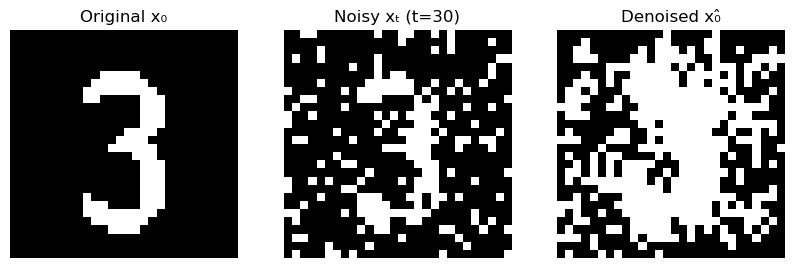


Epoch 25/30
  loss: 0.0085
  kl: 0.0007
  aux_ce: 0.7824
  steps: 469.0000
  val_aux_ce: 0.7818
  lr: 0.0001

  Denoising metrics on full train set:
    pixel_acc: 0.5806
    fg_acc: 0.9637
    bg_acc: 0.5223
    balanced_acc: 0.7430
    hamming: 0.4194
    mae: 0.4194


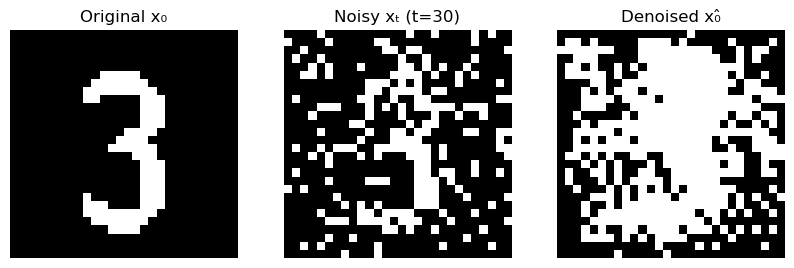


Epoch 26/30
  loss: 0.0085
  kl: 0.0007
  aux_ce: 0.7821
  steps: 469.0000
  val_aux_ce: 0.7808
  lr: 0.0000

  Denoising metrics on full train set:
    pixel_acc: 0.5806
    fg_acc: 0.9635
    bg_acc: 0.5223
    balanced_acc: 0.7429
    hamming: 0.4194
    mae: 0.4194


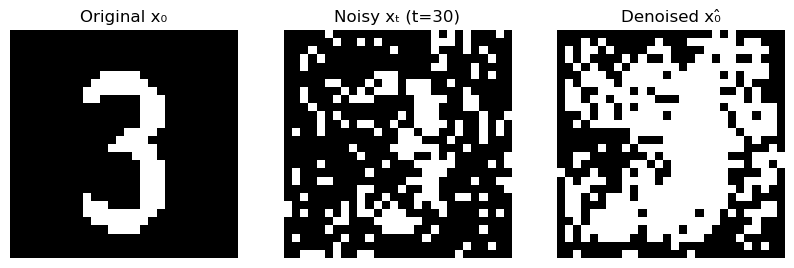


Epoch 27/30
  loss: 0.0085
  kl: 0.0007
  aux_ce: 0.7825
  steps: 469.0000
  val_aux_ce: 0.7822
  lr: 0.0000

  Denoising metrics on full train set:
    pixel_acc: 0.5806
    fg_acc: 0.9636
    bg_acc: 0.5222
    balanced_acc: 0.7429
    hamming: 0.4194
    mae: 0.4194


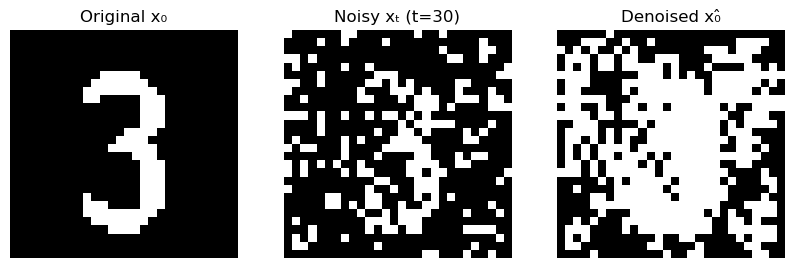


Epoch 28/30
  loss: 0.0085
  kl: 0.0007
  aux_ce: 0.7825
  steps: 469.0000
  val_aux_ce: 0.7819
  lr: 0.0000

  Denoising metrics on full train set:
    pixel_acc: 0.5806
    fg_acc: 0.9637
    bg_acc: 0.5223
    balanced_acc: 0.7430
    hamming: 0.4194
    mae: 0.4194


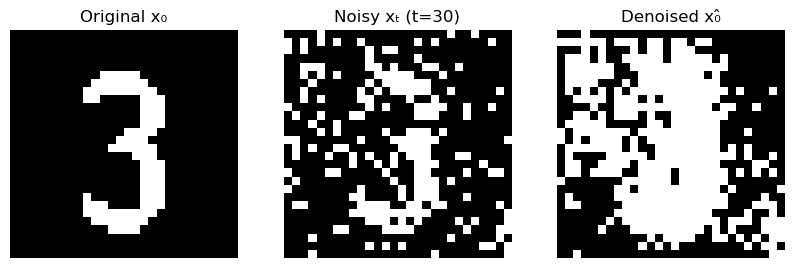


Epoch 29/30
  loss: 0.0085
  kl: 0.0007
  aux_ce: 0.7825
  steps: 469.0000
  val_aux_ce: 0.7805
  lr: 0.0000

  Denoising metrics on full train set:
    pixel_acc: 0.5806
    fg_acc: 0.9635
    bg_acc: 0.5223
    balanced_acc: 0.7429
    hamming: 0.4194
    mae: 0.4194


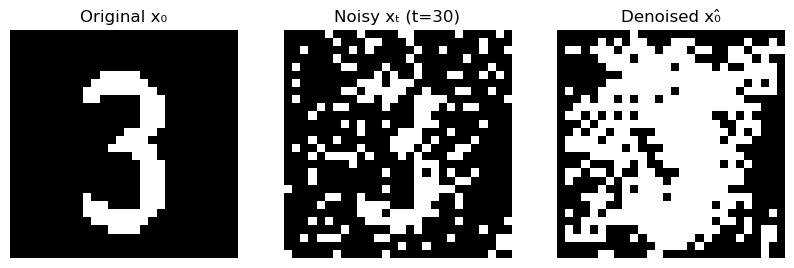


Epoch 30/30
  loss: 0.0085
  kl: 0.0007
  aux_ce: 0.7823
  steps: 469.0000
  val_aux_ce: 0.7820
  lr: 0.0000

  Denoising metrics on full train set:
    pixel_acc: 0.5806
    fg_acc: 0.9636
    bg_acc: 0.5222
    balanced_acc: 0.7429
    hamming: 0.4194
    mae: 0.4194


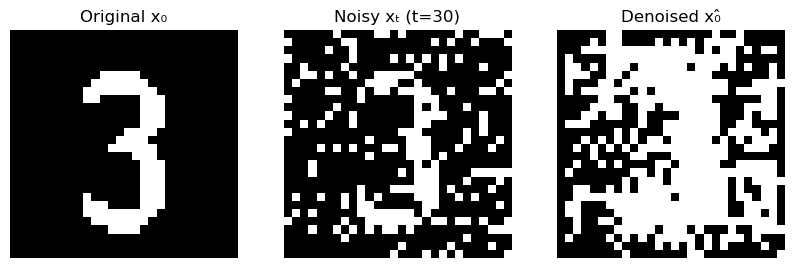

In [35]:
history = trainer.train(num_epochs=30, save_every=None, validate=True, print_every=1)